In [2]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from IPython import display
import matplotlib.pylab as plt
import ipywidgets
import glob
import os
import PIL.Image as Image

In [3]:
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU. This is important so things run faster.


In [4]:
class horse2zebra(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/scratch/horse2zebra',ctype='A'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        data_path = os.path.join(data_path,ctype)
        self.image_paths = glob.glob(data_path + '/*.jpg')
        self.label = 0 if ctype == 'A' else 1
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        image = np.array(image)
#         print(image.shape)
        if len(image.shape) == 2:
            image = np.dstack((image,image,image))
        image = Image.fromarray(image)
        
        # fetch folder name as the class type
        y = self.label
        X = self.transform(image)
        return X, y

In [5]:
def get_dataset(data_path='/scratch/horse2zebra/',image_size = (256,256),train=True):
    '''
    data loader
    '''
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
    
    horse = horse2zebra(train = train, transform=transform, data_path=data_path, ctype='A')
    zebra = horse2zebra(train = train, transform=transform, data_path=data_path, ctype='B')

    return horse, zebra



In [6]:
batch_size = 1
horse_ds, zebra_ds = get_dataset()

horse_loader = torch.utils.data.DataLoader(dataset=horse_ds,batch_size=batch_size,shuffle=True,num_workers=3)

zebra_loader = torch.utils.data.DataLoader(dataset=zebra_ds,batch_size=batch_size,shuffle=True,num_workers=3)

print((horse_ds[0][0].shape))
print(len(zebra_ds))


torch.Size([3, 256, 256])
1334


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

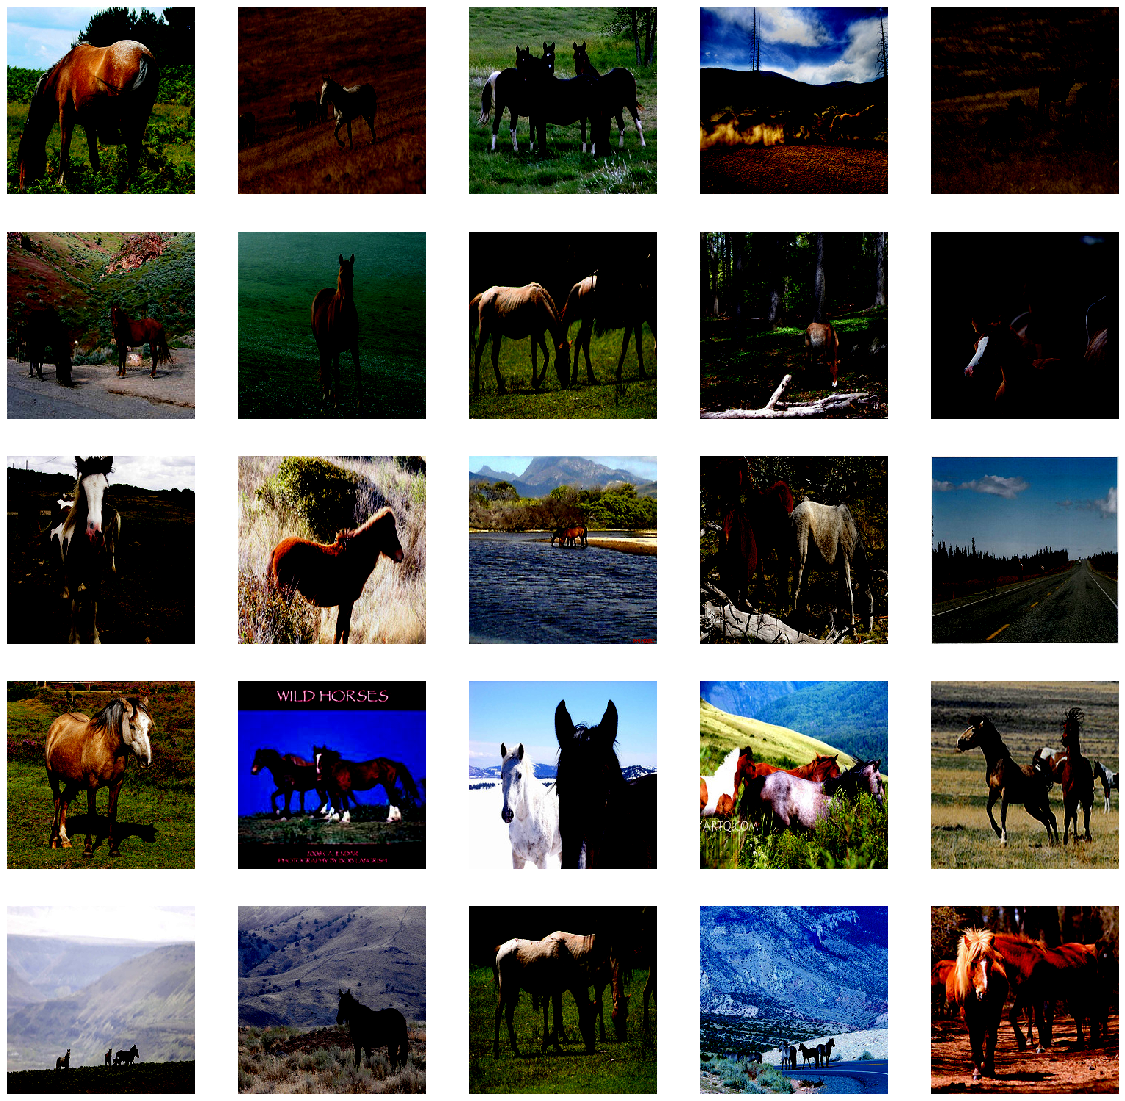

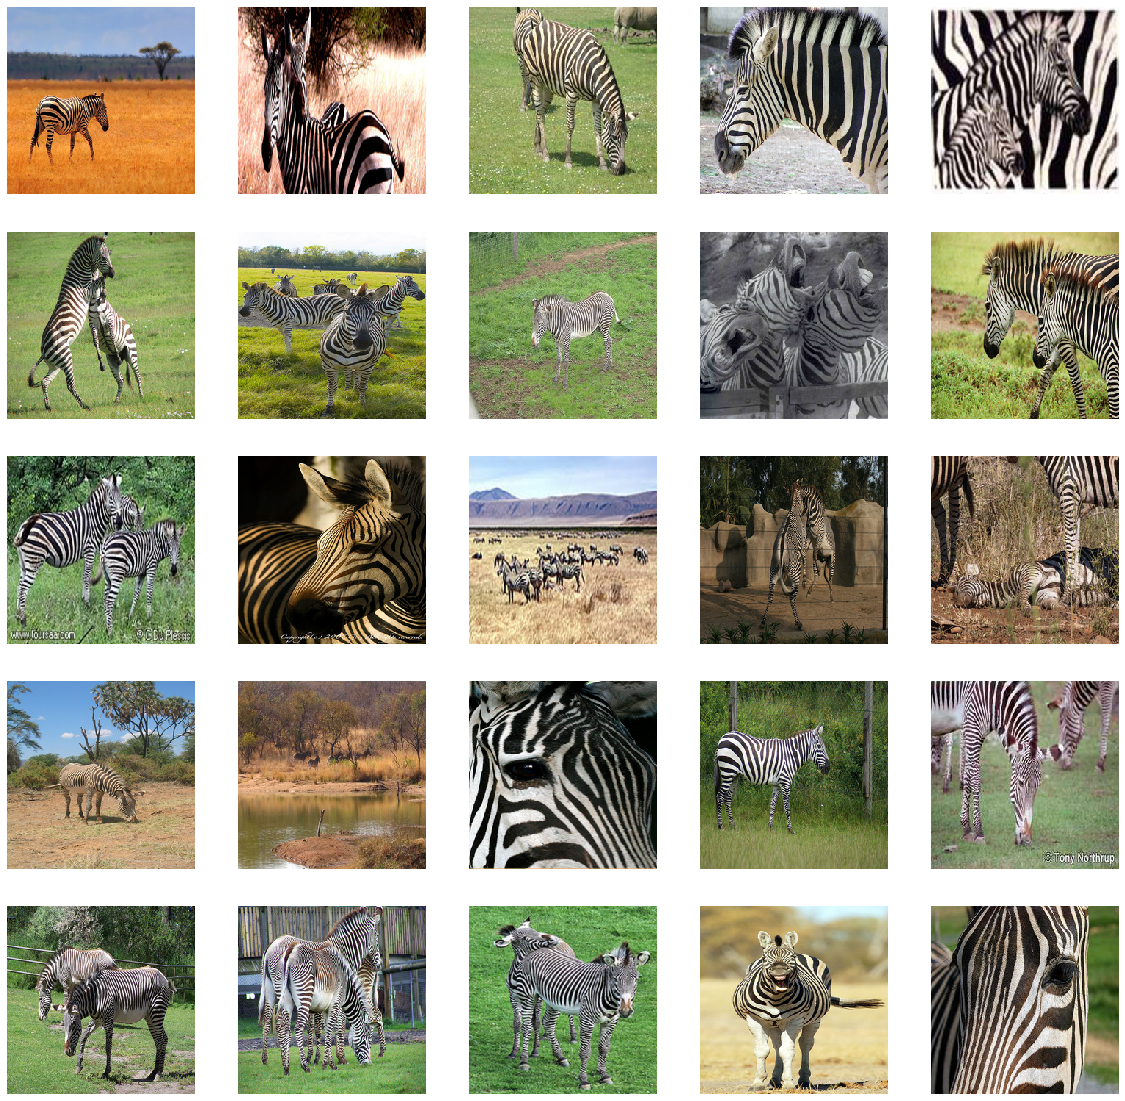

In [7]:
plt.figure(figsize=(20,20))

mean = np.array([0.5,0.5,0.5])
std = np.array([0.5,0.5,0.5])

i = 0
for img, _ in horse_loader:
    plt.subplot(5, 5, i+1)
    i+=1
    img = img[0,:,:,:].numpy()
    img = img.transpose(1,2,0)
#     print(img.shape)
#     transpose(2,1,0)
#     img = img * std.mean() + mean.mean()
    plt.imshow(img)
    plt.axis('off')
    if i >= 25:
        break

plt.figure(figsize=(20,20))
i = 0
for img, _ in zebra_loader:
    plt.subplot(5, 5, i+1)
    i+=1
    img = img[0,:,:,:].numpy()
    img = img.transpose(1,2,0)
#     print(img.shape)
#     transpose(2,1,0)
    img = img * std + mean
    plt.imshow(img)
    plt.axis('off')
    if i >= 25:
        break


## now we have data, we start create the model

In [8]:
class ResNetBlock(nn.Module):
    def __init__(self, n_features):
        super(ResNetBlock, self).__init__()
        # ...
        self.resblock = nn.Sequential(
            nn.Conv2d(n_features,n_features,kernel_size=3,
                      stride=1,padding=(1,1)),
            nn.InstanceNorm2d(n_features),
            nn.ReLU(),
            nn.Conv2d(n_features,n_features,kernel_size=3,stride=1,padding=(1,1))
        )
    
    def forward(self, x):
        # ...
        out = self.resblock(x);
        out+=x
        out = F.relu(out) ## could use leaky_relu?
        return out

In [9]:
def deconv(c_in, c_out, k_size, stride=2, padding=1, output_padding=0, bias = True, insn=True, relutype = 1, alpha=0.2):
    '''
    return deconvolusion layers
    '''
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, padding, bias=bias, output_padding=output_padding))

    if relutype == 1:
        layers.append(nn.LeakyReLU(alpha))
    else:
        layers.append(nn.ReLU())

    if insn:
        layers.append(nn.InstanceNorm2d(c_out))
    return nn.Sequential(*layers)

def conv(c_in, c_out, k_size, stride=2, padding=1, bias = True, insn=True, relutype = 1, alpha=0.2):
    '''
    return convolution layers
    '''    
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, padding, bias=bias))
    if relutype == 1:
        layers.append(nn.LeakyReLU(alpha))
    else:
        layers.append(nn.ReLU())
    
    if insn:
        layers.append(nn.InstanceNorm2d(c_out))
    return nn.Sequential(*layers)

class G(nn.Module):
    '''
    generator
    '''
    def __init__(self, input_features = 3, output_features = 3):
        super(G, self).__init__()
        # encoding blocks
        features = 64
        self.conv1 = conv(input_features, features, 7, stride=1, padding=3,relutype=2)
        self.conv2 = conv(features, features*2, 3, stride=2,padding=1,relutype=2)
        self.conv3 = conv(features*2, features*4, 3, stride=2,padding=1,relutype=2)  # 64 x 64 x256
        
        # residual blocks
        num_res_blocks = 9
        res_layers = []
        for i in range(num_res_blocks):
            res_layers.append(ResNetBlock(features*4))
        self.res_blocks = nn.Sequential(*res_layers)
        
        # decoding blocks
        self.deconv1 = deconv(features*4, features*2, 3, stride = 2, padding = 1, output_padding=1,relutype=2)
        self.deconv2 = deconv(features*2, features, 3, stride = 2, padding = 1, output_padding=1,relutype=2)
        self.conv4 = conv(features, output_features, 7, stride = 1, padding = 3,relutype=2)

        
    def forward(self, x):
        out = self.conv1(x)      # (?, 64, 256, 256)
        out = self.conv2(out)    # (?, 128, 128, 128)
        out = self.conv3(out)      # (?, 256, 64, 64)
        
        out = self.res_blocks(out)
        
        out = self.deconv1(out)  # (?, 128, 128, 128)
        out = self.deconv2(out)  # (?, 64, 256, 256) F.leaky_relu(
        out = torch.tanh(self.conv4(out))              # (?, 3, 256, 256)
        return out
    
class D(nn.Module):
    """Discriminator for mnist."""
    def __init__(self, input_features = 3, output_features = 1):
        super(D, self).__init__()
        conv_dim = 64
        self.conv1 = conv(input_features, conv_dim, 4, stride=2, padding=1, insn=False) ## 64x128
        self.conv2 = conv(conv_dim, conv_dim*2, 4, stride=2, padding=1,insn=True) ## 128x64
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4, stride=2, padding=1,insn=True) ## 256x32
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4, stride=1, padding=1,insn=True) ## 512x31

        ## patch gan
        self.conv5 = conv(conv_dim*8, output_features, 4, stride=1, padding=1,insn=True) # 1x30
#         self.conv6 = conv(output_features, output_features, 30, stride=1, padding=0) # 1x1
        
    def forward(self, x):
        out = self.conv1(x)    # (?, 64, 128, 128)
        out = self.conv2(out)  # (?, 128, 64, 64)
        out = self.conv3(out)  # (?, 256, 32, 32)
        out = self.conv4(out)  # (?, 512, 31, 31)
        out = self.conv5(out)  # (?, 1, 30, 30)
#         out = self.conv6(out).squeeze() # (?,1,1,1)
        return out

In [10]:
def lsgan_loss_d(dx, dz):
    b = 1
    return 0.5*torch.mean((dx - b)**2)+0.5*torch.mean((dz)**2)

def lsgan_loss_g(dz):
    c = 1
    return 0.5*torch.mean((dz-c)**2)

In [11]:
A_loader = horse_loader
B_loader = zebra_loader

beta1 = 0.5
beta2 = 0.999
lr = 0.0002

gA2B = G()
gB2A = G()
dA = D()
dB = D()
        
g_params = list(gA2B.parameters()) + list(gB2A.parameters())
d_params = list(dA.parameters()) + list(dB.parameters())

g_optimizer = torch.optim.Adam(g_params, lr, [beta1, beta2])
d_optimizer = torch.optim.Adam(d_params, lr, [beta1, beta2])

        
gA2B.to(device)
gB2A.to(device)
dA.to(device)
dB.to(device)

A_iter = iter(A_loader)
B_iter = iter(B_loader)

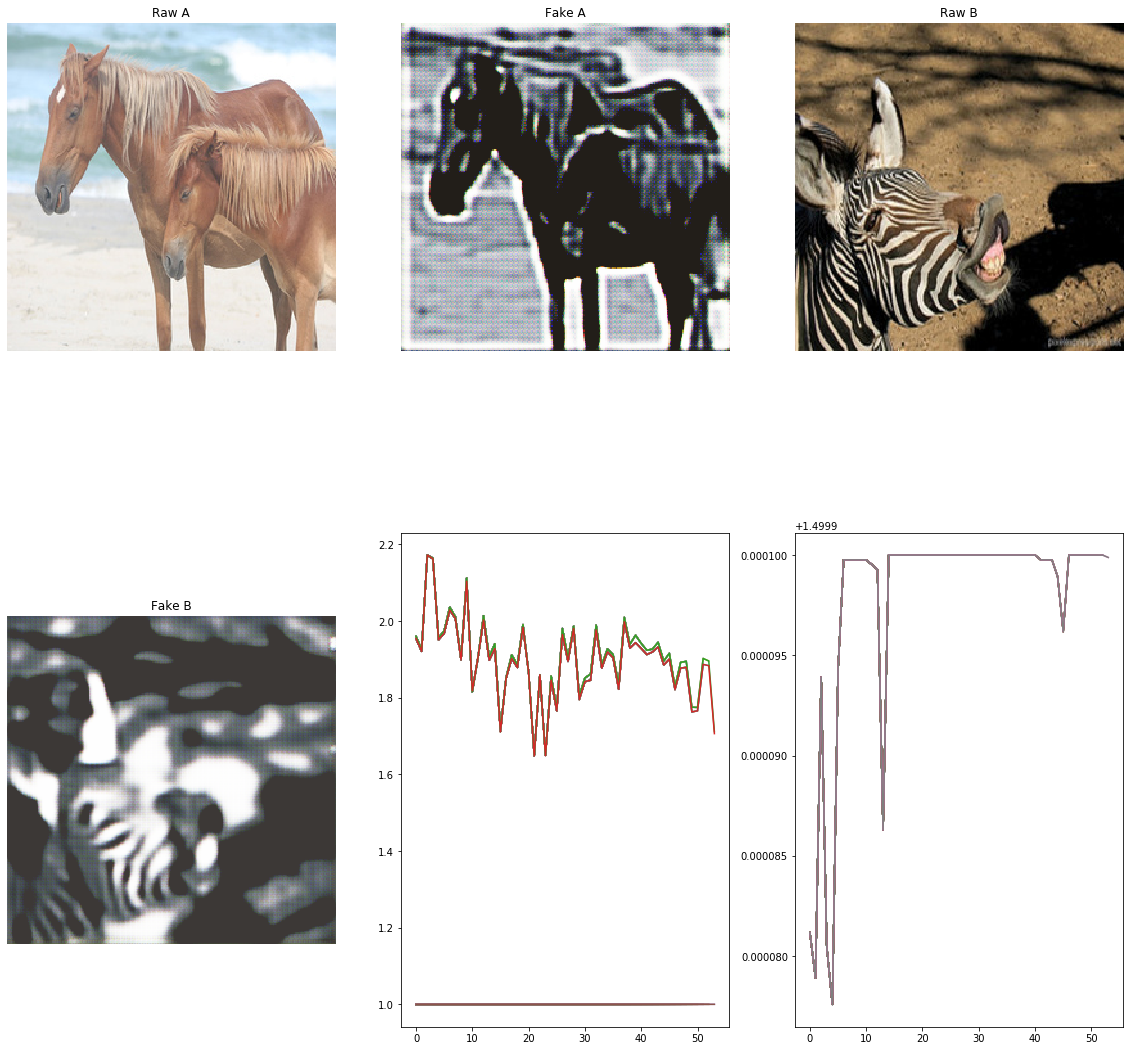

In [ ]:
iter_per_epoch = min(len(A_iter), len(B_iter))

# sampling image
fixed_A = A_iter.next()[0].to(device)
fixed_B = B_iter.next()[0].to(device)

visualization = ipywidgets.Output()
display.display(visualization)
with visualization:
    plt.figure(figsize=(20,20))
subplots = [plt.subplot(2, 3, k+1) for k in range(6)]
        
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()
    
epochs = 30

losses_ind = []
losses_da = []
losses_db = []
losses_cycle = []
losses_gana = []
losses_ganb = []

for epoch in tqdm(range(epochs)): 
    A_iter = iter(A_loader)
    B_iter = iter(B_loader)
    
    loss_ind = []
    loss_da = []
    loss_db = []
    loss_cycle = []
    loss_gana = []
    loss_ganb = []
    
    for step in tqdm(range(iter_per_epoch)):
        # load data
        imgA, label_A = A_iter.next() 
        imgA, label_A = imgA.to(device), label_A.to(device)

        imgB, label_B = B_iter.next() 
        imgB, label_B = imgB.to(device), label_B.to(device)
        
        imgA = imgA*2-1
        imgB = imgA*2-1
        
        #============ train D ============#
        # train with real images
        d_optimizer.zero_grad()
        outAA = dA(imgA)
        with torch.no_grad(): 
            outBA = dA(gB2A(imgB))
        da_gan_loss = lsgan_loss_d(outAA,outBA)

        outBB = dB(imgB)
        with torch.no_grad(): 
            outAB = dB(gA2B(imgA))
        db_gan_loss = lsgan_loss_d(outBB,outAB)
        
        loss_da.append(da_gan_loss)
        loss_db.append(db_gan_loss)
        
        da_gan_loss.backward()
        db_gan_loss.backward()
        d_optimizer.step()

        #============ train G ============#
        g_optimizer.zero_grad()
        
        # Identity loss
        loss_id_A = criterion_identity(gB2A(imgA), imgA)
        loss_id_B = criterion_identity(gA2B(imgB), imgB)
        loss_identity = (loss_id_A + loss_id_B) / 2
        
        loss_ind.append(loss_identity)
        
        # add cycle loss
        fake_B = gA2B(imgA)
        g_gan_loss_A = lsgan_loss_g(dB(fake_B))
        rec_A = gB2A(fake_B)
        loss_cycle_A = criterion_cycle(rec_A, imgA)
#         g_cycle_loss = torch.mean((rec_A-imgA)**2)
        fake_A = gB2A(imgB)
        g_gan_loss_B = lsgan_loss_g(dA(fake_A))
        rec_B = gA2B(fake_A)
        loss_cycle_B = criterion_cycle(rec_B, imgB)

        loss_cyc = (loss_cycle_A + loss_cycle_B) / 2
        loss_GAN = (g_gan_loss_A+g_gan_loss_B)/2
        
        loss_cycle.append(loss_cyc)
        loss_gana.append(g_gan_loss_A)
        loss_ganb.append(g_gan_loss_B)

        # Total loss
        g_loss = loss_GAN + 10 * loss_cyc + 0.5 * loss_identity

        g_loss.backward()
        g_optimizer.step()
        
        # show the sampled images per 100 
        if (step+1) % 30 == 0:
            fake_A = gA2B(fixed_A)
            fake_B = gB2A(fixed_B)

            # show
            imga = fixed_A[0,:,:,:].cpu().numpy().transpose(1,2,0)
            imgfa = fake_A.cpu().detach()
            imgfa = imgfa[0,:,:,:].numpy()
            imgfa = imgfa.transpose(1,2,0)
            imga = imga * std + mean
            imgfa = imgfa * std + mean

            imgb = fixed_B[0,:,:,:].cpu().numpy().transpose(1,2,0)
            imgfb = fake_B.cpu().detach()
            imgfb = imgfb[0,:,:,:].numpy()
            imgfb = imgfb.transpose(1,2,0)
            imgb = imgb * std + mean
            imgfb = imgfb * std + mean

            subplots[0].imshow(imga)
            subplots[0].set_title('Raw A')
            subplots[0].axis('off')

            subplots[1].imshow(imgfa)
            subplots[1].set_title('Fake A')
            subplots[1].axis('off')   

            subplots[2].imshow(imgb)
            subplots[2].set_title('Raw B')
            subplots[2].axis('off')

            subplots[3].imshow(imgfb)
            subplots[3].set_title('Fake B')
            subplots[3].axis('off')
            
            loss = np.array(loss_ind,dtype=np.float32)
            losses_ind.append(loss.mean())
            
            loss = np.array(loss_cycle,dtype=np.float32)
            losses_cycle.append(loss.mean())
            
            loss = np.array(loss_gana,dtype=np.float32)
            losses_gana.append(loss.mean())
            
            loss = np.array(loss_ganb,dtype=np.float32)
            losses_ganb.append(loss.mean())
            
            loss = np.array(loss_da,dtype=np.float32)
            losses_da.append(loss.mean())
            
            loss = np.array(loss_db,dtype=np.float32)
            losses_db.append(loss.mean())
            
            
            loss_ind.clear()
            loss_da.clear()
            loss_db.clear()
            loss_cycle.clear()
            loss_gana.clear()
            loss_ganb.clear()
    
            
            subplots[4].plot(losses_ind,label='loss_ind')
            subplots[4].plot(losses_cycle,label='loss_cycle')
            subplots[5].plot(losses_gana,label='loss_gana')
            subplots[5].plot(losses_ganb,label='loss_ganb')
            subplots[6].plot(losses_da,label='loss_da')
            subplots[6].plot(losses_db,label='loss_db')

            display.display(plt.gcf())
            display.clear_output(wait=True)

    print('epoch: %d finish, save model'%(epoch))
    model_path = './model'
    #save the model parameters for each epoch
    gAB_path = os.path.join(model_path, 'gab-%d.pkl' %(step+1))
    gBA_path = os.path.join(model_path, 'gba-%d.pkl' %(step+1))
    dA_path = os.path.join(model_path, 'da-%d.pkl' %(step+1))
    dB_path = os.path.join(model_path, 'db-%d.pkl' %(step+1))
    torch.save(gA2B.state_dict(), gAB_path)
    torch.save(gB2A.state_dict(), gBA_path)
    torch.save(dA.state_dict(), dA_path)
    torch.save(dB.state_dict(), dB_path)

In [ ]:
loss_db = np.array(loss_db,dtype=np.float32)
print(loss_db.mean())
a = [1,2,3,4,5]
b = [2,4,5,6,10]
plt.plot(a)
plt.plot(b)